Assignment 3: 

Name: Jeffin Johny K

UID: 118293929

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: Jeffin Johny

In [1]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from cmath import isnan

# Part 1: Epipolar Geometry (30 Points)


## Overview

In this problem, you will implement an algorithm for automatically estimating the fundamental matrix F using RANSAC and the normalized 8-point algorithm. In the file matches.mat, we provide the detected Harris corners row-column positions in variables r1 c1 for the first image; variables r2 c2 for the second image; and the corresponding matched pairs in the variable matches.

<!-- <img src="https://drive.google.com/uc?id=1Tr723u5OXmwkd4RDmu9z886ITJU9j1cL&export=download" width="800"/> -->

<img src="https://drive.google.com/uc?id=17mwO8QH24vw1Kv1aBONgFXKi53HqUMEd&export=download" width="800"/>


The outline of the normalized 8-point algorithm:

<img src="https://drive.google.com/uc?id=1nVnvBpKeLmiowT9Q4_QauogXpcdXBmHm&export=download" width="700"/>



## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [2]:
# Download Data -- run this cell only one time per runtime
!gdown 1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
!unzip "/content/Part1_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part1_data/matches.mat')
r1 = data['r1']
r2 = data['r2']
c1 = data['c1']
c2 = data['c2']
matches = data['matches']

Downloading...
From: https://drive.google.com/uc?id=1cn3_SscjlLrf4BzUWe8MV-XqMqBY4Nj_
To: /content/Part1_data.zip
100% 157k/157k [00:00<00:00, 86.6MB/s]
Archive:  /content/Part1_data.zip
   creating: /content/Part1_data/
  inflating: /content/Part1_data/chapel00.png  
  inflating: /content/Part1_data/chapel01.png  
  inflating: /content/Part1_data/matches.mat  


In [3]:
# Load Keypoints
x1 = c1[matches[:,0]-1]
y1 = r1[matches[:,0]-1]
x2 = c2[matches[:,1]-1]
y2 = r2[matches[:,1]-1]

## Helper Functions

In [4]:
from scipy.ndimage import gaussian_filter as gf
from google.colab.patches import cv2_imshow

def show_image(img, scale=1.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray() 
    plt.axis('off')
    plt.show()


### Code (15 pt)

In [5]:
def ransacF(x1, y1, x2, y2):
  """Ransac for fundamental matrix

  Args:
      x1 (np.ndarray):  x coordinates from img1
      y1 (np.ndarray):  y coordinates from img1
      x2 (np.ndarray):  x coordinates from img2
      y2 (np.ndarray):  y coordinates from img2

  Returns:
      np.ndarray , np.ndarray: denormalised Fun matrix , inlier index storage
  """  


  thresh = 0.05   #0.5
  iterations = 25000    #25000
  best_count = 0 
  F_final = np.zeros((3,3))
  best_dist = np.inf
  safe_index = np.zeros((1,x1.shape[0]))

  # Normalize the coordinates
  norm_x1 , norm_y1 , T1_norm = normalize(x1 , y1)   
  norm_x2 , norm_y2 , T2_norm = normalize(x2 , y2)  


  for i in range(iterations):
    # CHoose 8 random points from dataset 
    rand_8 = np.random.randint( 0 , x1.shape[0] , size = 8)

    x1_8 = np.hstack((  norm_x1[rand_8[0], :] , norm_x1[rand_8[1] ,:] , norm_x1[rand_8[2] ,:] , norm_x1[rand_8[3] ,:],
                          norm_x1[rand_8[4] ,:] , norm_x1[rand_8[5] ,:] , norm_x1[rand_8[6] ,:] , norm_x1[rand_8[7] ,:] ))

    y1_8 = np.hstack((  norm_y1[rand_8[0], :] , norm_y1[rand_8[1] ,:] , norm_y1[rand_8[2] ,:] , norm_y1[rand_8[3] ,:],
                          norm_y1[rand_8[4] ,:] , norm_y1[rand_8[5] ,:] , norm_y1[rand_8[6] ,:] , norm_y1[rand_8[7] ,:] ))

    x2_8 = np.hstack((  norm_x2[rand_8[0], :] , norm_x2[rand_8[1] ,:] , norm_x2[rand_8[2] ,:] , norm_x2[rand_8[3] ,:],
                          norm_x2[rand_8[4] ,:] , norm_x2[rand_8[5] ,:] , norm_x2[rand_8[6] ,:] , norm_x2[rand_8[7] ,:] )) 

    y2_8 = np.hstack((  norm_y2[rand_8[0], :] , norm_y2[rand_8[1] ,:] , norm_y2[rand_8[2] ,:] , norm_y2[rand_8[3] ,:],
                          norm_y2[rand_8[4] ,:] , norm_y2[rand_8[5] ,:] , norm_y2[rand_8[6] ,:] , norm_y2[rand_8[7] ,:] ))         

    # Compute F for those chosen
    F = computeF(x1_8 , y1_8 , x2_8 , y2_8)
    # Apply the F to entire dataset and check for inliers
    inlier_count , total_dist , inlier_index= getInliers( norm_x1, norm_y1 , norm_x2 , norm_y2 , F , thresh)

    # Check condition to store the F matrix with max. inliers
    if inlier_count>best_count or (inlier_count==best_count and total_dist<best_dist):
      best_count = inlier_count
      best_dist = total_dist
      safe_index = inlier_index
      F_final = F

  # Denormalised F matrix
  F_denormal = T1_norm.T@F_final@T2_norm

  return F_denormal , safe_index


def getInliers( x1_list , y1_list , x2_list , y2_list, F, thresh):
  """implement the criteria checking inliers. 

  Args:
      x1_list (np.ndarray): normalised x coordinates from x1
      y1_list (np.ndarray): normalised y coordinates from y1
      x2_list (np.ndarray): normalised x coordinates from x2
      y2_list (np.ndarray): normalised y coordinates from y2
      F (np.ndarray): Fundamental matrix
      thresh (float): threshhold

  Returns:
      _type_: gives back inlier count, sum of disatnces and inlier indexs in given dataset
  """  

  N = x1_list.shape[0]
  count = 0

  # Stacking points '2'
  X_2 = np.vstack(( x2_list.reshape(1 , -1) , y2_list.reshape(1 , -1) , np.ones((1,N))))
  # Getting epilines equations using points 2, which will be present in image '1'  
  l2 = F@X_2
  l2_a = l2[0, :]
  l2_b = l2[1, :]
  l2_c = l2[2, :]

  # vectorised distances of points '1' from line 'l2'
  d_1_vect = abs((l2_a * x1_list.reshape(1 , -1) + l2_b * y1_list.reshape(1 , -1) + l2_c)) / (np.sqrt(l2_a * l2_a + l2_b * l2_b))

  #line for x1 y1
  # Stacking points '1'
  X_1 = np.vstack(( x1_list.reshape(1 , -1) , y1_list.reshape(1 , -1) , np.ones((1,N))))
  # Getting epilines equations using points 1, which will be present in image '2'  
  l1 = F.T@X_1
  l1_a = l1[0, :]
  l1_b = l1[1, :]
  l1_c = l1[2, :]
  # vectorised distances of points '2' from line 'l1'
  d_2_vect = abs((l1_a * x2_list.reshape(1 , -1) + l1_b * y2_list.reshape(1 , -1) + l1_c)) / (np.sqrt(l1_a * l1_a + l1_b * l1_b))

  # Summing up corresponding distances
  d_sum = d_1_vect + d_2_vect

  # Threshhold ceck and storing the indices of inliers
  inlier_index = np.argwhere( d_sum<thresh )
  # COunt of inliers
  count = inlier_index.shape[0]
  # Total sum of distances
  dis_sum = np.sum(d_sum)

  return count , dis_sum , inlier_index


def normalize(x, y):
  """find the transformation to make it zero mean and the variance as sqrt(2)


  Args:
      x (np.ndarray): size(N,1) , x-coordinates of datapoints
      y (np.ndarray): size(N,1) , y-coordinates of datapoints
  Returns:
      np.ndarray: normalised x, normalised y , Transformation matrix
  """  

  # Calculating the mean and variance
  x_mean = np.mean(x)
  y_mean = np.mean(y)

  proper_xy = np.hstack(( x , y ))
  std_check = np.std(proper_xy)

  # Tranformation matrix to make 0 mean and sqrt(2) std
  T_norm = np.array([ [(np.sqrt(2)/std_check) , 0 , -(x_mean*np.sqrt(2)/std_check)] ,
                      [ 0 , (np.sqrt(2)/std_check) , -(y_mean*np.sqrt(2)/std_check)] ,
                      [ 0 , 0 , 1]    ] )

  # making matrix of size (3,N)
  pts_3d = np.vstack((  x.reshape(1,-1) , y.reshape(1,-1) ,  np.ones((1 , x.shape[0])) ))

  # Points transformed
  pts_norm = np.matmul(T_norm , pts_3d)
  
  # Getting normalized x and y coordinates
  pts_norm_x = pts_norm[0 , :].reshape(-1 , 1)
  pts_norm_y = pts_norm[1 , :].reshape(-1 , 1) 

  return pts_norm_x , pts_norm_y , T_norm   


  
def computeF(x1, y1, x2, y2):
  """compute fundamental matrix from corresponding points

  Args:
      x1 (np.ndarray): size(1,8)
      y1 (np.ndarray): size(1,8)
      x2 (np.ndarray): size(1,8)
      y2 (np.ndarray): size(1,8)

  Returns:
      np.ndarray: rank 2 matrix
  """  

  # Af = 0
  A = np.array([[x1[0]*x2[0] , x1[0]*y2[0] , x1[0] , y1[0]*x2[0] , y1[0]*y2[0] , y1[0] , x2[0] , y2[0], 1],
                [x1[1]*x2[1] , x1[1]*y2[1] , x1[1] , y1[1]*x2[1] , y1[1]*y2[1] , y1[1] , x2[1] , y2[1], 1] ,
                [x1[2]*x2[2] , x1[2]*y2[2] , x1[2] , y1[2]*x2[2] , y1[2]*y2[2] , y1[2] , x2[2] , y2[2], 1] ,
                [x1[3]*x2[3] , x1[3]*y2[3] , x1[3] , y1[3]*x2[3] , y1[3]*y2[3] , y1[3] , x2[3] , y2[3], 1] ,
                [x1[4]*x2[4] , x1[4]*y2[4] , x1[4] , y1[4]*x2[4] , y1[4]*y2[4] , y1[4] , x2[4] , y2[4], 1] ,
                [x1[5]*x2[5] , x1[5]*y2[5] , x1[5] , y1[5]*x2[5] , y1[5]*y2[5] , y1[5] , x2[5] , y2[5], 1] ,
                [x1[6]*x2[6] , x1[6]*y2[6] , x1[6] , y1[6]*x2[6] , y1[6]*y2[6] , y1[6] , x2[6] , y2[6], 1] ,
                [x1[7]*x2[7] , x1[7]*y2[7] , x1[7] , y1[7]*x2[7] , y1[7]*y2[7] , y1[7] , x2[7] , y2[7], 1]])
  
  U, S , Vt =np.linalg.svd(A)

  F = Vt[-1,:]  
  F = np.reshape(F , (3,3))
  # Eforcing rank = 2, by making the third singular value 0
  Uf , Sf , Vt_f = np.linalg.svd(F)

  Sf = np.diag(Sf[:3])
  Sf[-1 , -1] = 0

  F_rank2 = Uf@Sf@Vt_f
  return F_rank2


def rand_pts(in_index , rand_7 , ip_pts):
  """To stack 7 coordinates(x or y) from inlier points

  Args:
      in_index (np.ndarray): contains index position of datapoints which are inliers
      rand_7 (np.ndarray): random numbers 
      ip_pts (np.ndarray): datapoints (x1 /x2 /y1 /y2 )

  Returns:
      np.ndarray: stack of points
  """        
  # Storing datapoint indices which are inliers
  r1 = in_index[rand_7[0], 1]
  r2 = in_index[rand_7[1], 1]
  r3 = in_index[rand_7[2], 1]
  r4 = in_index[rand_7[3], 1]
  r5 = in_index[rand_7[4], 1]
  r6 = in_index[rand_7[5], 1]
  r7 = in_index[rand_7[6], 1]

  return np.hstack((  ip_pts[ r1 ] , ip_pts[r2] , ip_pts[r3] , ip_pts[r4],
                      ip_pts[r5] ,ip_pts[r6] , ip_pts[r7]  ))


def get_y(x , order , a, b, c):
  """To get 'y' coordinates for line eqn(ax+by+c=0)

  Args:
      x (np.ndarray): values ranging from 0 to width of image
      order (int): current match number
      a (float): coef of line eqn
      b (float): coef of line eqn
      c (float): coef of line eqn

  Returns:
      np.ndarray: y coordinate
  """  
  y = (-c[order]-a[order]*x)/b[order]
  return y



Normalised F matrix: 
 [[-4.47318694e-06  2.79315051e-06  3.06466881e-02]
 [-7.07163046e-05 -1.31547865e-05  4.69001106e-01]
 [-1.78316961e-02 -4.38034601e-01  7.66098203e-01]]
inliers count 159


Text(0.5, 1.0, ' image 2')

<Figure size 432x288 with 0 Axes>

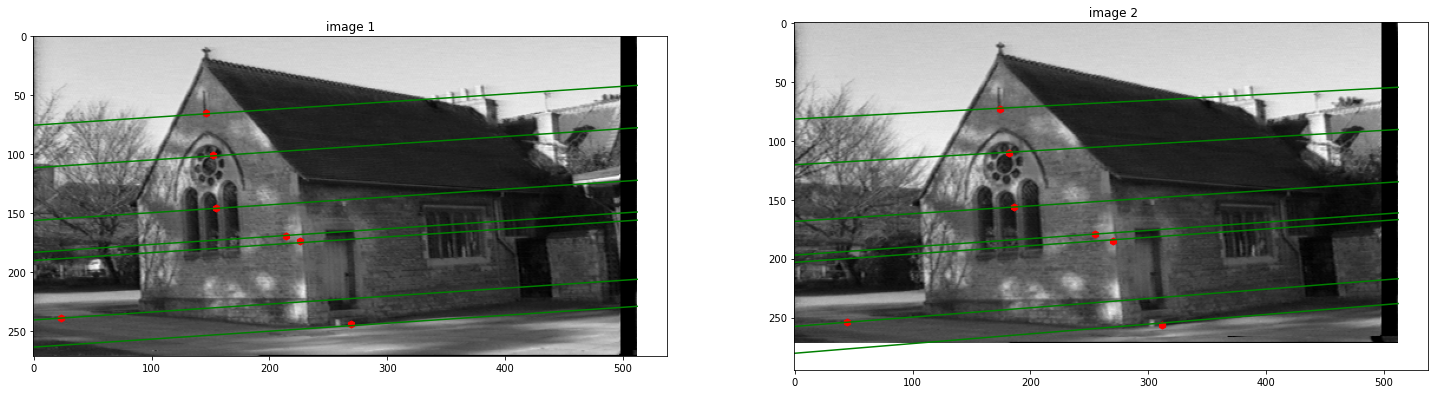

In [7]:
# Implementing ransac to get F matrix
F_out , in_index = ransacF(x1 , y1 , x2 , y2)
F_display = F_out/np.linalg.norm(F_out)

print(f"Normalised F matrix: \n {F_display}")
# read the images
img1 = cv2.imread('/content/Part1_data/chapel00.png' ,0)  
img2 = cv2.imread('/content/Part1_data/chapel01.png' , 0)

# Storing 7 random inlier matches
rand_7 = np.random.choice(  in_index.shape[0] , size = 7 , replace = False) 

x1_7 = rand_pts(in_index , rand_7 , x1)
y1_7 = rand_pts(in_index , rand_7 , y1)
x2_7 = rand_pts(in_index , rand_7 , x2)
y2_7 = rand_pts(in_index , rand_7 , y2)


print(f"inliers count {in_index.shape[0]}")

# Using points '2' to determine the corresponding line equations in img '1'. 
X_2 = np.vstack(( x2_7.reshape(1 , -1) , y2_7.reshape(1 , -1) , np.ones((1,7))))
l2 = F_out@X_2
l2_a = l2[0, :]
l2_b = l2[1, :]
l2_c = l2[2, :]


# Using points '1' to determine the corresponding line equations in img '2'. 
X_1 = np.vstack(( x1_7.reshape(1 , -1) , y1_7.reshape(1 , -1) , np.ones((1,7))))
l1 = F_out.T@X_1
l1_a = l1[0, :]
l1_b = l1[1, :]
l1_c = l1[2, :]

# Generating x coordinates for plotting 
x = np.linspace(0, img1.shape[1],100)

sizes = [50]

## PLOTTING ##
plt.figure()
plt.figure(figsize = (25, 25))

plt.subplot(1,2,1),plt.imshow(img1,cmap = 'gray')
plt.scatter(x1_7[:] , y1_7[:] , color ='r' , marker ='h' , s=sizes) 
for i in range(7):
    plt.plot(x, get_y(x , i , l2_a, l2_b, l2_c), 'g' )
plt.title('image 1')

plt.subplot(1,2,2),plt.imshow(img2,cmap = 'gray')
plt.scatter(x2_7[:] , y2_7[:] , color ='r' , marker ='h' , s=sizes) 
for i in range(7):
    plt.plot(x, get_y(x , i , l1_a, l1_b, l1_c), 'g' )
plt.title(' image 2')

### Write-up (15 pt)
*   Describe what test you used for deciding inlier vs. outlier.
*   Display the estimated fundamental matrix F after normalizing to unit length
*   Randomly select 7 sets of matching points. Plot the corresponding epipolar lines and the points on each image. Show the two images (with plotted points and lines) next to each other.

<!-- *   Plot the outlier keypoints with green dots on top of the first image -->
<!-- *   Randomly select 7 sets of matching points. Plot the corresponding epipolar lines ('g’) and the points (with 'r+’) on each image. Show the two images (with plotted points and lines) next to each other. -->



### Answers:
1. Ransac was implemented to get the best model. Steps are as follows:
   *   Select 8 random matches and solve for F matrix.
   *   Now take points (x2,y2) of image2 and compute the corresponding equations of epilines (L2) by multiplying by F.
   *  These lines(L2) lies on the img1 and ideally the corresponding matches (x1,y1) should be on them. So distance(d1) is computed for all points(x1,y1) from their corresponding epilines.
   * Similarly, (x1,y1) is taken and lines (L1) are computed by multiplying (F.Transpose). Then distance (d2) is computed for all points(x2,y2) from their corresponding epilines.
   * Then for each match (d1+d2) is calculated and checked whether its less than threshhold. And whichever satisfies this condition is chosen as inlier.
   * So the model is selected which has maximum number of inliers. A secondary condition is added to look for, if total distance is small(ie. sum of (d1+d2 for all matches)
2. Printed Above
3. Displayed above


### Hint

*   You can use cv2.cornerHarris in opencv.
*   For visualization, you can use cv2.line, cv2.circle or any other helper functions in opencv or matplotlib.


# Part 2: Image stitching (30 points)

<img src="https://drive.google.com/uc?id=1uOI8rpqb_FsR9Fi8GrGPZvICOcgflBj9&export=download" width="800"/>

## Overview

In this problem, you will implement an algorithm for automatically estimating homography with RANSAC. 

Image Stitching Algorithm Overview
1. Detect keypoints
2. Match keypoints
3. Estimate homography with matched keypoints (using RANSAC)
4. Combine images

**Note:**  Do not use existing image stitching code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [8]:
# Download Data -- run this cell only one time per runtime
!gdown 1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
!unzip "/content/hill.zip" -d "/content/hill"

!gdown 1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
!unzip "/content/tv.zip" -d "/content/tv"


Downloading...
From: https://drive.google.com/uc?id=1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
To: /content/hill.zip
100% 205k/205k [00:00<00:00, 98.8MB/s]
Archive:  /content/hill.zip
  inflating: /content/hill/1.JPG     
  inflating: /content/hill/2.JPG     
  inflating: /content/hill/3.JPG     
Downloading...
From: https://drive.google.com/uc?id=1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
To: /content/tv.zip
100% 130k/130k [00:00<00:00, 63.4MB/s]
Archive:  /content/tv.zip
  inflating: /content/tv/1.jpg       
  inflating: /content/tv/2.jpg       
  inflating: /content/tv/3.jpg       


### Code (15 pt)

In [9]:
def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

def plot_matches(img1 , kp_1 , img2 , kp_2 , matches):
    """plot matches after sift

    """    
    good_draw = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good_draw.append([m])
    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(img1, kp_1 , img2 , kp_2 , good_draw,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    # plt.figure()
    # plt.figure(figsize = (10, 10))
    # plt.imshow(img3 ,cmap = 'gray')

    # plt.title("Matches")

def est_homography(src, dest):
    """compute homography matrix from corresponding points

    Args:
        src (np.ndarray):  4 source points of size (4X2)
        dest (np.ndarray): 4 destination points of size (4X2)

    Returns:
       np.ndarray: Homography matrix
    """    
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)

    h = V[-1,:]/V[-1,-1]
    h = np.array(h)
    return np.reshape(h ,(3 ,3 ))


def apply_homography(H, src):
    """Computes dst points after Homo applied to src points

    Args:
        H (np.ndarray): Homography matrix
        src (np.ndarray): size(N,2)

    Returns:
        np.ndarray: dst points of size(N,2)
    """    
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]


def good_matches(i1 , i2 , dst_right_img):
    """Applying SIft and ratio test 

    Args:
        i1 (np.ndarray): grayscale image
        i2 (np.ndarray): grayscale image
        dst_right_img (bool): To check whether the right image is destination

    Returns:
       (np.ndarray) , (np.ndarray) , (int): the good matchpoints and their count
    """    
    img1_copy = i1.copy()
    img2_copy = i2.copy()
        
    sift = cv2.SIFT_create()
    # detect SIFT features in both images
    kp_1, des_1 = sift.detectAndCompute(img1_copy,None)
    kp_2, des_2 = sift.detectAndCompute(img2_copy,None)

    bf = cv2.BFMatcher()
    
    if dst_right_img:
        # Match descriptors.
        matches = bf.knnMatch(des_1 ,des_2, k=2)

        # Apply ratio test
        good = []
        for m,n in matches:
            if m.distance < 0.4*n.distance:
                good.append(m)
        # Atleast 10 good points required 
        if len(good)>10:
            src_pts = np.float32([ kp_1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)  

    else :
        # Match descriptors.
        matches = bf.knnMatch(des_2 ,des_1, k=2)

        # Apply ratio test
        good = []
        for m,n in matches:
            if m.distance < 0.4*n.distance:
                good.append(m)
        # Atleast 10 good points required 
        if len(good)>10:
            src_pts = np.float32([ kp_2[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_1[m.trainIdx].pt for m in good ]).reshape(-1,1,2) 

    plot_matches(img1_copy , kp_1 , img2_copy , kp_2 , matches)
    return src_pts , dst_pts , len(good)



def ransac_H(src , dst , good_matches):
    """Ransac for homography matrix

    Args:
        src (np.ndarray): source points
        dst (np.ndarray): destination points
        good_matches (int): number of points

    Returns:
        np.ndarray: denormalised homography matrix
    """    
    thresh = 1
    iterations = 50
    best_count = 0 
    H_final = np.zeros((3,3))
    best_dist = np.inf

    # Normalize the coordinates
    norm_src_x , norm_src_y , T_src_norm = normalize_kp(src , good_matches)
    # Stacking to make them of the form (N,2)
    norm_src = np.hstack((  norm_src_x.reshape(-1 ,1) , norm_src_y.reshape(-1 ,1) ))

    norm_dst_x , norm_dst_y , T_dst_norm = normalize_kp(dst , good_matches)
    norm_dst = np.hstack((  norm_dst_x.reshape(-1 ,1) , norm_dst_y.reshape(-1 ,1) ))

    for i in range(iterations):
        # CHoose 4 random points from dataset to compute model 
        rand_4 = np.random.randint( 0 , good_matches , size = 4)
        src_4 = np.vstack((  norm_src[rand_4[0] ,:] , norm_src[rand_4[1] ,:] , norm_src[rand_4[2] ,:] , norm_src[rand_4[3] ,:] ))
        dst_4 = np.vstack((  norm_dst[rand_4[0] ,:] , norm_dst[rand_4[1] ,:] , norm_dst[rand_4[2] ,:] , norm_dst[rand_4[3] ,:] ))
    
        # Compute H for those chosen
        H = est_homography( src_4 , dst_4 )
        # Destination points found after homography
        dst_after_homo = apply_homography(H , norm_src)

        # COmputing L2 norm between newly computed and existing points
        dist = np.linalg.norm(dst_after_homo - norm_dst , axis =1)
        dis_sum = np.sum(dist)
        # Check whether each disarnce is below threshhold
        inlier_find = np.where( dist<thresh , 1 , 0)
        # Get inlier count
        count = np.sum(inlier_find)

    # Check condition to store the H matrix with max. inliers
        if count>best_count or (count==best_count and dis_sum<best_dist):
            best_count = count
            best_dist = dis_sum

            H_final = H

    # Denormalise the H matirx
    H_recapture = np.linalg.inv(T_dst_norm) @ H_final @ T_src_norm

    return H_recapture 

def normalize_kp(pts, good_matches):
    """find the transformation to make it zero mean and the variance as sqrt(2)

    Args:
        pts (_type_): points to normalized
        good_matches (int): number of points

    Returns:
        (np.ndarray) , (np.ndarray) , (np.ndarray) : normalised points and their transformation matrix
    """    

    # Calculating the mean and variance
    x_mean = np.mean(pts[: , 0 , 0])
    y_mean = np.mean(pts[: , 0 , 1])

    proper_xy = np.hstack((  pts[: , 0 , 0].reshape(-1 ,1) , pts[: , 0 , 1].reshape(-1 ,1) ))
    std_check = np.std(proper_xy)

    # Tranformation matrix to make 0 mean and sqrt(2) std
    T_norm = np.array([ [(np.sqrt(2)/std_check) , 0 , -(x_mean*np.sqrt(2)/std_check)] ,
                        [ 0 , (np.sqrt(2)/std_check) , -(y_mean*np.sqrt(2)/std_check)] ,
                        [ 0 , 0 , 1]    ] )

    # making matrix of size (3,N)
    pts_3d = np.vstack((  pts[: , 0 , 0].reshape(1,-1), pts[: , 0 , 1].reshape(1,-1) ,  np.ones((1 , good_matches)) ))

    # Points transformed
    pts_norm = np.matmul(T_norm , pts_3d)
    # Getting normalized x and y coordinates
    pts_norm_x = pts_norm[0 , :]
    pts_norm_y = pts_norm[1 , :] 

    return pts_norm_x , pts_norm_y , T_norm 


def stitch_images(img1 , img2 , img3):
    """Stitches all the images to create a panorama

    Args:
        img1 (np.ndarray): Left image of the given 3
        img2 (np.ndarray): Middle image of 3
        img3 (np.ndarray): Right image of 3
    """    
    RGB_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    RGB_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    RGB_img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
    # convert images to grayscale
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) #query
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) # train
    img3_gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

    # Padding the middle image, so that the left image after homography stays in the resultant frame
    middle_img = np.zeros((img1_gray.shape[0] , img1_gray.shape[1]+img2_gray.shape[1]) , dtype = np.uint8)
    middle_img[: , img1_gray.shape[1]:] = img2_gray

    # STITCHING from LEFT to RIGHT
    # Finding matches between left and middle image
    src , dst , match_count = good_matches(img1_gray , middle_img , True)
    # Applying homography to transform points from img1 to img2 plane
    H_1 = ransac_H(src , dst , match_count)

    print(f"best H where right img is destination, (img1=src) and (img2=dst) \n{H_1}")

    dst = cv2.warpPerspective(RGB_img1 ,H_1,(img1.shape[1] + img2.shape[1], img2.shape[0]))
    dst[:, img2.shape[1]:] = RGB_img2

    # STITCHING from RIGHT to LEFT
    # The prior stitched image and the third img3
    src_2 , dst_2 , match_count_2 = good_matches(dst, img3_gray, False)
    # Applying homography to transform points from img3 to img2 plane
    H_2 = ransac_H(src_2 , dst_2 , match_count_2)

    print(f"best H where left img is destination (img3=src) and (img2=dst)\n{H_2}")

    panorama = cv2.warpPerspective(RGB_img3 , H_2,(dst.shape[1] + img3_gray.shape[1], img3_gray.shape[0]))
    panorama[:, :dst.shape[1]] = dst


    plt.figure()
    plt.figure(figsize = (15, 15))
    plt.imshow(panorama ,cmap = 'gray')

### Write-up (15 pt)
*  Describe how to remove incorrect matches with RANSAC 
*  Display the best homography H after RANSAC 
*  Display the blended images

### Answers:
1. Ransac was used on normalised coordinates to compute the best H matrix. Steps as followed:
  *  4 random matches were chosen to compute the model(H matrix).
  *  The source coordinates(src) is transformed to new destination points(dst_new) using the above H matrix.
  *  Then the euclidean distances between newly found points(dst_new) and original destination points(dst) are computed.
  * The matches which had distance less than threshhold, were chosen as inliers.
  * So the model is selected which has maximum number of inliers. A secondary condition is added to look for, if total distance is small.
  * The above steps are repeated for a certain number of iterations and the best H value is chosen. Then the H matrix is denormalised and send back.

2. The 2 H(denormalised) matrices are displayed for each dataset. Total 4, are printed below.
3. Displayed below.

best H where right img is destination, (img1=src) and (img2=dst) 
[[ 1.16120382e+00 -8.49411457e-02  2.18553689e+02]
 [ 9.92286341e-02  9.83544375e-01 -2.49156767e+00]
 [ 3.17918990e-04 -7.52296157e-05  9.22056286e-01]]
best H where left img is destination (img3=src) and (img2=dst)
[[ 8.18417626e-01  4.03981715e-02  5.51907332e+02]
 [-4.81363132e-02  1.00935165e+00 -1.64192018e+01]
 [-2.77739977e-04  5.24244377e-05  1.02984884e+00]]


<Figure size 432x288 with 0 Axes>

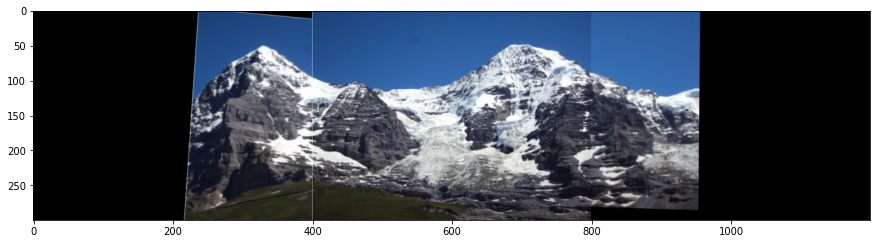

In [10]:
# read the images

hill1 = cv2.imread('/content/hill/1.JPG' )  
hill2 = cv2.imread('/content/hill/2.JPG' )
hill3 = cv2.imread('/content/hill/3.JPG' )

stitch_images(hill1 , hill2 , hill3)

best H where right img is destination, (img1=src) and (img2=dst) 
[[ 1.47095864e+00  2.70969581e-02  5.23363157e+01]
 [ 2.40685410e-01  1.02609636e+00 -9.37533709e+01]
 [ 7.86253791e-04  2.78896201e-05  7.18942192e-01]]
best H where left img is destination (img3=src) and (img2=dst)
[[ 4.83640908e-01  1.17458097e-02  7.29911381e+02]
 [-1.84176572e-01  9.99504378e-01  2.07402156e+01]
 [-6.19751528e-04  2.07808058e-05  1.06309799e+00]]


<Figure size 432x288 with 0 Axes>

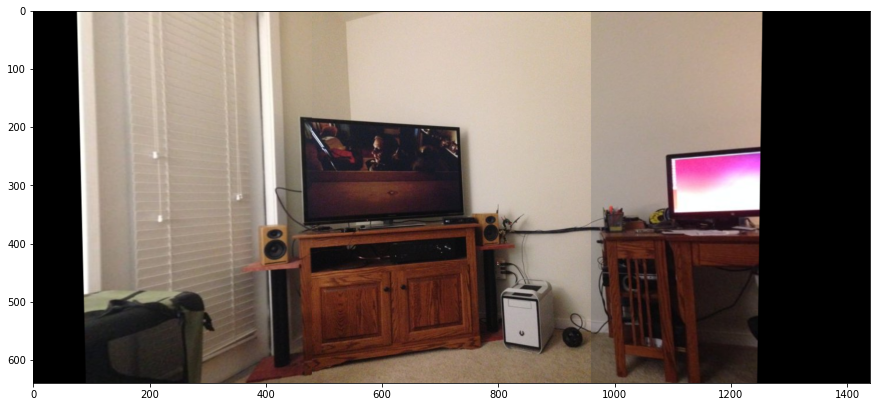

In [11]:
# read the images
tv1 = cv2.imread('/content/tv/1.jpg' )  
tv2 = cv2.imread('/content/tv/2.jpg' )
tv3 = cv2.imread('/content/tv/3.jpg' )

stitch_images(tv1 , tv2 , tv3)

### Hint


*   Use Harris Corner Detection to find keypoint. You can use cv2.cornerHarris in opencv.
*   For image warping and blending, you should first deterimne canvas size. You can use cv2.warpPerspective in opencv. 


# Part 3: Affine Structure from Motion (40 points)

## Overview
<img src="https://drive.google.com/uc?id=1nYd0eJjBtVIPuapfxuiVzswjswGN_Gq2&export=download" width="800"/>


This problem continues the interest point detection and tracking problem from HW2. Now, you will recover a 3D pointcloud from the image sequence hotel.seq0.png … hotel.seq50.png. You are encouraged to use your results from HW2, but in case you were not able to complete it, we have also included pre- computed intermediate results in the supplemental material. Submit your code so that we can reproduce your results.

The outline of the affine structure from motion algorithm:

<img src="https://drive.google.com/uc?id=1BSvHwRR5gNBwDGlrk-dcLCRcuIAvab__&export=download" width="700"/>


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [12]:
# Download Data -- run this cell only one time per runtime
!gdown 1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
!unzip "/content/Part2_data.zip" -d "/content/"
# Load Matches
data = loadmat('/content/Part2_data/tracks.mat')

Downloading...
From: https://drive.google.com/uc?id=1A0Rin_YMmWkExjI99vfLYvU_dy-9gFTT
To: /content/Part2_data.zip
100% 5.44M/5.44M [00:00<00:00, 165MB/s]
Archive:  /content/Part2_data.zip
   creating: /content/Part2_data/
   creating: /content/Part2_data/images/
  inflating: /content/Part2_data/images/hotel.seq0.png  
  inflating: /content/Part2_data/images/hotel.seq1.png  
  inflating: /content/Part2_data/images/hotel.seq10.png  
  inflating: /content/Part2_data/images/hotel.seq11.png  
  inflating: /content/Part2_data/images/hotel.seq12.png  
  inflating: /content/Part2_data/images/hotel.seq13.png  
  inflating: /content/Part2_data/images/hotel.seq14.png  
  inflating: /content/Part2_data/images/hotel.seq15.png  
  inflating: /content/Part2_data/images/hotel.seq16.png  
  inflating: /content/Part2_data/images/hotel.seq17.png  
  inflating: /content/Part2_data/images/hotel.seq18.png  
  inflating: /content/Part2_data/images/hotel.seq19.png  
  inflating: /content/Part2_data/images/hot

### Code (20 pt)

In [13]:
track_x = data['track_x']
track_y = data['track_y']


def affineSFM(x, y):
  """Retreives camera motion and 3d scene points from 2d images

  Args:
      x (np.ndarray): tracked x points across all frames
      y (np.ndarray): tracked y points across all frames

  Returns:
      (np.ndarray) , (np.ndarray) , (int): motion matrix, 3d sccene points and frame number
  """  


  pts_num , frame_num = x.shape

  track_x_new = np.zeros((1 , frame_num))
  track_y_new = np.zeros((1 , frame_num))

  # Removing points which goes out of track
  for i in range(pts_num):
    nan_present = False
    for j in range(frame_num):
      if np.isnan(x[i , j]):
        nan_present = True

    if not nan_present:
      if track_x_new.shape[0]==1:
        track_x_new = x[i , :]
        track_y_new = y[i , :]
      else :
        track_x_new = np.vstack((track_x_new , x[i , :]))
        track_y_new = np.vstack((track_y_new , y[i , :]))


  mean_x = np.mean(track_x_new , axis = 0 , keepdims=True)
  mean_y = np.mean(track_y_new , axis = 0 , keepdims=True)
  # Making points zero mean 
  centered_x = (track_x_new-mean_x).T
  centered_y = (track_y_new-mean_y).T

  # Computing Observation matrix
  D = np.vstack((centered_x , centered_y))

  U, W, Vt = np.linalg.svd(D)
  # For rank 3
  U_3 = U[: , :3]
  Vt_3 = Vt[:3 , :]
  W_3 = np.diag(W[:3])

  W_3_sqrt = np.sqrt(W_3)
  # Camera motion matrix
  M = U_3@W_3_sqrt
  print(f"camear motion{M.shape}")

  S = W_3_sqrt@Vt_3
  print(f"scene pts{S.shape}")

  A_tilde = np.zeros((3,9))
  b = np.zeros((3 ,1))
  # Computing orthographic constraints
  
  for i in range(0 ,frame_num):
    i_dir = M[i , :].reshape(1,-1)
    j_dir = M[i+frame_num , :].reshape(1,-1)

    i_dir_T = M[i , :].reshape(-1,1)
    j_dir_T = M[i+frame_num , :].reshape(-1,1)
    
    # (iXj) contraint
    row_1 = (i_dir_T@j_dir).flatten()
    # (iXi) contraint
    row_2 = (i_dir_T@i_dir).flatten()
    # (jXj) contraint
    row_3 = (j_dir_T@j_dir).flatten()

    if i ==0:
      A_tilde[0 , :] , b[0 , :]= row_1 , 0
      A_tilde[1 , :] , b[1 , :] = row_2 , 1
      A_tilde[2 , :] , b[2 , :] = row_3 , 1
    else:
      A_tilde = np.vstack( (A_tilde , row_1 , row_2 , row_3) )
      b = np.vstack((b , 0 , 1 , 1))

  L = np.linalg.pinv(A_tilde)@b
  L = L.reshape(3 ,3)
  # Cholosky decompositon
  cholo_L = np.linalg.cholesky(L)

  A = M@cholo_L
  X = np.linalg.inv(cholo_L)@S
  
  return A , X , frame_num

  
Cam_mot , scene_pt , frame_no= affineSFM(track_x , track_y)

def point_cloud_3d(scene_pt , ele , azi):
  """displays 3d point cloud

  Args:
      scene_pt (np.ndarray): 3d scene points
      ele (int): elevation angle for display
      azi (int): azimuth angle for display
  """  
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(111, projection='3d')

  ax.set_title("3d point cloud")

  xdata = scene_pt[0,:]
  ydata = scene_pt[1,:]
  zdata = scene_pt[2,:]

  elev=ele
  azim=azi
  ax.view_init(elev, azim)
  ax.set_axis_off
  ax.scatter(xdata, ydata, zdata, c='r', marker='x');
  ax.grid(False)
  plt.show()  


def plot_cam(Cam_mot , frame_no):
  """plots x,y and z values across all the frames

  Args:
      Cam_mot (np.array): contains camera axes info for each frame
      frame_no (int): frame number
  """  
    
  x_cam_axis = Cam_mot[:frame_no , :]
  y_cam_axis = Cam_mot[frame_no: , :]
  # Getting axis perpendicular to x and y
  cam_k = np.cross(x_cam_axis , y_cam_axis)

  norm_cross = np.linalg.norm(cam_k , axis = 1 , keepdims=True)
  # Normalise  the coordinates
  norm_k = cam_k/norm_cross

  norm_x , norm_y , norm_z = np.hsplit(norm_k , 3)
  x_coord = np.arange(frame_no)

  plt.figure()
  plt.figure(figsize = (25, 10))

  plt.subplot(1,3,1)
  plt.plot(x_coord[:], norm_x[:], 'g' )
  plt.title('x direction')

  plt.subplot(1,3,2)
  plt.plot(x_coord[:], norm_y[:], 'g' )
  plt.title('y direction')

  plt.subplot(1,3,3)
  plt.plot(x_coord[:], norm_z[:], 'g' )
  plt.title('z direction')

camear motion(102, 3)
scene pts(3, 400)


### Write-up (20 pt)


*   Plot the predicted 3D locations of the tracked points for 3 different viewpoints. Choose the viewpoints so that the 3D structure is clearly visible.
*   Plot the predicted 3D path of the cameras. The camera position for each frame is given by the cross product a_k = a_i x a_j. Normalize a_k to be unit length for consistent results. Give 3 plots, one for each dimension of a_k 
<!-- We provide the function plotSfM.m for visualizing the recovered 3D shape and camera positions in each frame. -->


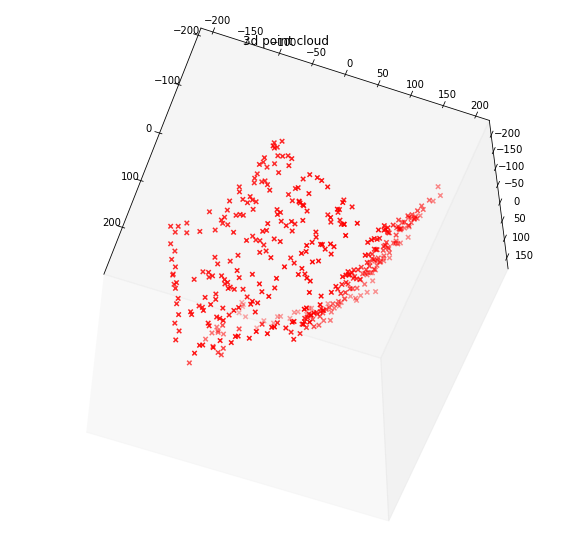

In [14]:
point_cloud_3d(scene_pt , 120 ,20)

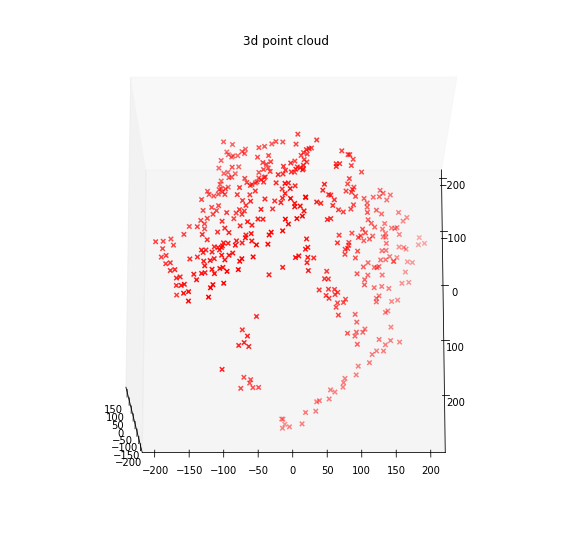

In [15]:
point_cloud_3d(scene_pt , 75 ,0)

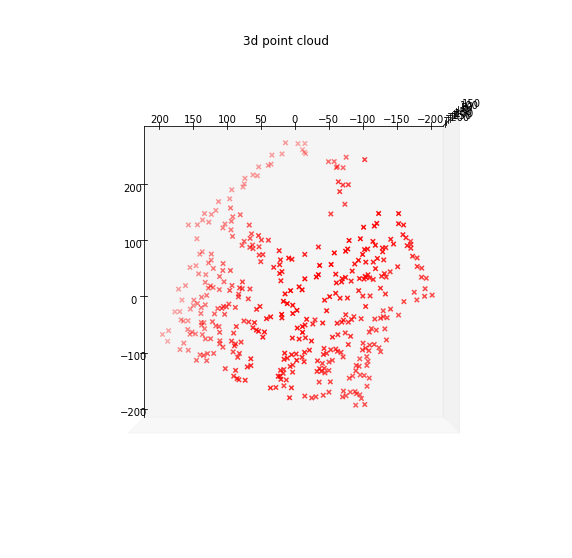

In [16]:
point_cloud_3d(scene_pt , 90 ,180)

<Figure size 432x288 with 0 Axes>

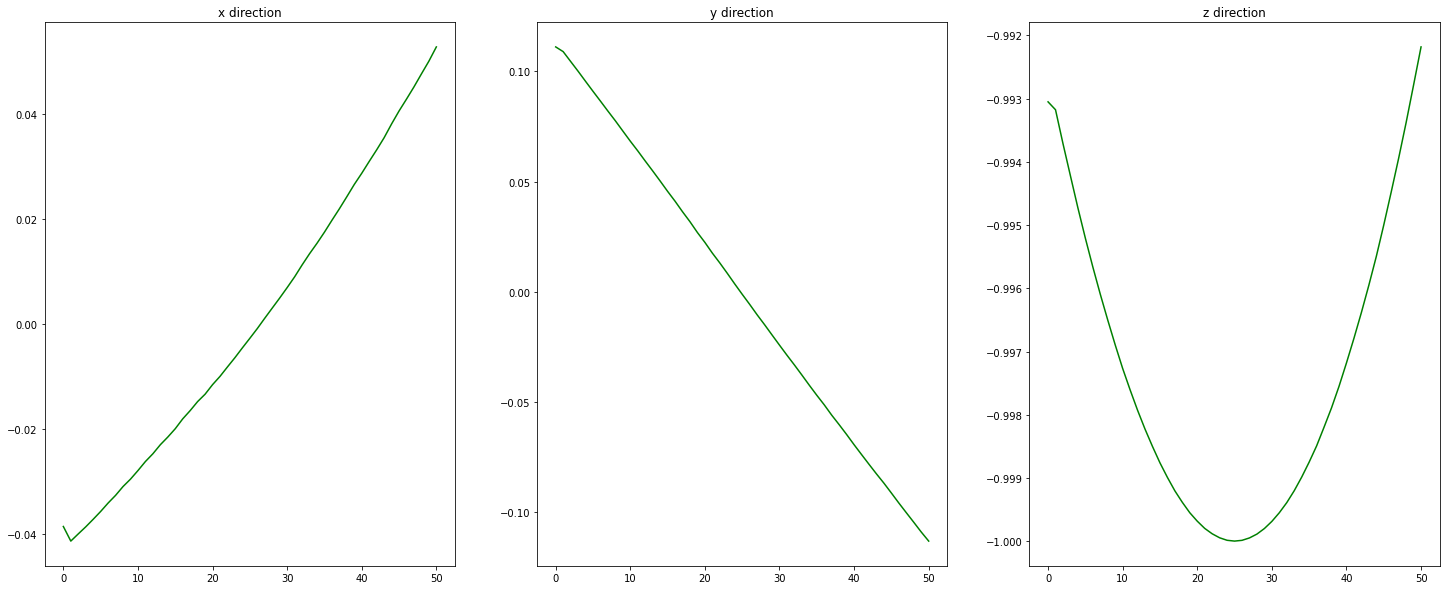

In [17]:
plot_cam(Cam_mot , frame_no)

### Hint


*   Do not use existing structure from motion code, such as found in OpenCV.
*   The provided file tracks.mat contains the tracked keypoints over 51 frames.viewpoints. 
*   Reference: 
    - Tomasi and Kanade. Shape and Motion from Image Streams under Orthography: a Factorization Method. 1992